# Libraries

In [318]:
import os
import pandas as pd
from tqdm.notebook import tqdm
import shutil
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
import time
from keras.utils import np_utils
from keras import backend as K
from sklearn.manifold import TSNE
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
import gzip
from io import StringIO
import glob
from sklearn.model_selection import train_test_split

In [2]:
train_mfcc_features = np.load('train_mfccs_DCASE_2017.npy')
validation_mfcc_features = np.load('validation_mfccs_DCASE_2017.npy')
 
train_labels = np.load('train_labels_DCASE_2017.npy')
validation_labels =np.load('validation_labels_DCASE_2017.npy')
 
train_label_encoder = LabelEncoder().fit(train_labels)
train_labels = train_label_encoder.transform(train_labels)
classes_train = list(train_label_encoder.classes_)
 
validation_label_encoder = LabelEncoder().fit(validation_labels)
validation_labels = validation_label_encoder.transform(validation_labels)
classes_validation = list(validation_label_encoder.classes_)

In [3]:
classes_train

['indoor', 'outdoor', 'vehicle']

In [4]:
train_scaled = []
for i in range(len(train_mfcc_features)):
    scaler_train = StandardScaler().fit(train_mfcc_features[i])
    scaled_train = scaler_train.transform(train_mfcc_features[i])
    train_scaled.append(scaled_train)

In [5]:
validation_scaled = []
for i in range(len(validation_mfcc_features)):
    scaler_validation = StandardScaler().fit(validation_mfcc_features[i])
    scaled_validation = scaler_validation.transform(validation_mfcc_features[i])
    validation_scaled.append(scaled_validation)

In [6]:
validation_scaled[1].shape

(13, 431)

In [625]:
X_train = train_scaled
y_train = np_utils.to_categorical(train_labels)
 
X_val = validation_scaled
y_val = np_utils.to_categorical(validation_labels)

In [565]:
print(len(X_train))
print(X_train[1].shape)
print(X_train[1].mean(axis=1).shape)
print(X_train[1].std(axis=1).shape)

X_train_mean = []
X_train_std = []
for i in range(len(X_train)):
    X_train_mean.append(X_train[i].mean(axis=1))
    X_train_std.append(X_train[i].std(axis=1))
    
print(len(X_train_mean))
print(len(X_train_std))

X_train_new = np.concatenate((X_train_mean, X_train_std), axis=1)

3507
(13, 431)
(13,)
(13,)
3507
3507


In [566]:
X_train_new.shape

(3507, 26)

In [567]:
print(len(X_val))
print(X_val[1].shape)
print(X_val[1].mean(axis=1).shape)
print(X_val[1].std(axis=1).shape)

X_val_mean = []
X_val_std = []
for i in range(len(X_val)):
    X_val_mean.append(X_val[i].mean(axis=1))
    X_val_std.append(X_val[i].std(axis=1))
    
print(len(X_val_mean))
print(len(X_val_std))

X_val_new = np.concatenate((X_val_mean, X_val_std), axis=1)

1173
(13, 431)
(13,)
(13,)
1173
1173


# 1D Convolutional Parameters

In [626]:
NB_ROWS = 26     # corresponds to number of mfccs
NB_COLS = 1    # correponds to the size of mfccs[i] (one mfcc)
 
X_train = np.array(X_train_new)
X_val = np.array(X_val_new)
 
# Reshaping to perform 1D convolution
X_train_1D_cnn = X_train.reshape(X_train.shape[0], NB_ROWS, NB_COLS)
X_test_1D_cnn = X_val.reshape(X_val.shape[0], NB_ROWS, NB_COLS)
 
y_train_1D_cnn_hot = y_train
y_test_1D_cnn_hot = y_val
 
print("[INFO] X_train_1D_cnn.shape = {}, y_train_1D_cnn_hot.shape = {} ".format(X_train_1D_cnn.shape, 
                                                                                y_train_1D_cnn_hot.shape))
print("[INFO] X_test_1D_cnn.shape = {}, y_test_1D_cnn_hot.shape = {} ".format(X_test_1D_cnn.shape, 
                                                                              y_test_1D_cnn_hot.shape))
 
# debug
print("[DEBUG] y_train_1D_cnn_hot.shape = {}, y_train_1D_cnn_hot[0] = {}".format(y_train_1D_cnn_hot.shape, 
                                                                                 y_train_1D_cnn_hot[0]))
print("[DEBUG] y_test_1D_cnn_hot.shape = {}, y_test_1D_cnn_hot[0] = {}".format(y_test_1D_cnn_hot.shape, 
                                                                               y_test_1D_cnn_hot[0]))

[INFO] X_train_1D_cnn.shape = (3507, 26, 1), y_train_1D_cnn_hot.shape = (3507, 3) 
[INFO] X_test_1D_cnn.shape = (1173, 26, 1), y_test_1D_cnn_hot.shape = (1173, 3) 
[DEBUG] y_train_1D_cnn_hot.shape = (3507, 3), y_train_1D_cnn_hot[0] = [0. 1. 0.]
[DEBUG] y_test_1D_cnn_hot.shape = (1173, 3), y_test_1D_cnn_hot[0] = [0. 1. 0.]


In [571]:
def construct_model(input_shape=(26, 1), num_classes = 3):
     
    model = Sequential()
    model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=input_shape))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv1D(32, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(32, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.25))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax', name="output_layer"))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    model.summary()
     
    inp = model.input                                                               # input placeholder
    outputs = [layer.output for layer in model.layers]                              # all layer outputs
    functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions
     
    return model

In [572]:
epochs = 100
batch_size = 32
verbose = 1
num_classes = 3
input_shape = (NB_ROWS, NB_COLS)
 
outputFolder = "D:\\Extrasensory_Journal"
 
# Create the model and fit it
start = time.time()
model = construct_model(input_shape=input_shape, num_classes=num_classes)
filepath = outputFolder + "\\DCASE_2017_1D-mfccs-weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss',
                             verbose=verbose,
                             save_best_only=True,
                             save_weights_only=True, 
                             mode='auto')
 
earlystop = EarlyStopping(monitor='val_loss', 
                          patience=7,
                          verbose=verbose, 
                          mode='auto')
 
callbacks_list = [checkpoint, earlystop]
history = model.fit(X_train_1D_cnn, 
                    y_train_1D_cnn_hot, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    callbacks=callbacks_list,
                    verbose=verbose, 
                    validation_data=(X_test_1D_cnn, y_test_1D_cnn_hot))
end = time.time()
 
print("[INFO] Model trained in {} ms".format((end-start)))
model.save('DCASE_2017_mfccs_1D_k4.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 25, 32)            96        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 32)            2080      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)              

Epoch 00027: val_loss improved from 0.25965 to 0.25658, saving model to D:\Extrasensory_Journal\DCASE_2017_1D-mfccs-weights.hdf5
Epoch 28/100
3507/3507 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.93 - ETA: 0s - loss: 0.2122 - accuracy: 0.91 - ETA: 0s - loss: 0.2094 - accuracy: 0.92 - ETA: 0s - loss: 0.2414 - accuracy: 0.90 - ETA: 0s - loss: 0.2429 - accuracy: 0.90 - ETA: 0s - loss: 0.2350 - accuracy: 0.91 - ETA: 0s - loss: 0.2271 - accuracy: 0.91 - 0s 121us/step - loss: 0.2251 - accuracy: 0.9162 - val_loss: 0.2648 - val_accuracy: 0.9147

Epoch 00028: val_loss did not improve from 0.25658
Epoch 29/100
3507/3507 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.93 - ETA: 0s - loss: 0.1919 - accuracy: 0.93 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.2050 - accuracy: 0.92 - ETA: 0s - loss: 0.2101 - accuracy: 0.91 - ETA: 0s - loss: 0.2120 - accuracy: 0.91 - ETA: 0s - loss: 0.2200 - accuracy: 0.91 - ETA: 0s - loss: 0.2249 - 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


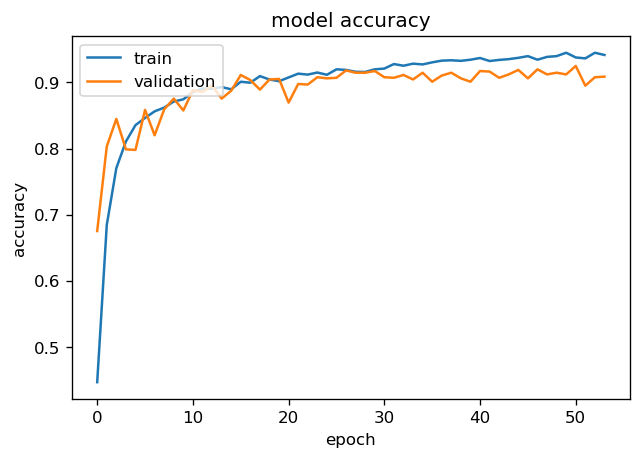

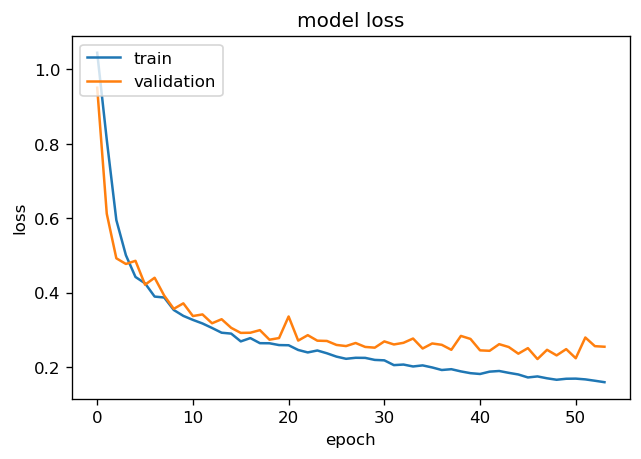

Training accuracy: 94.15% / Validation accuracy: 90.88%


In [573]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(dpi=120)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

 
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" %
      (100*history.history['accuracy'][-1], 100*history.history['val_accuracy'][-1]))

# Confusion Matrix DCASE_2017 Development 1D MFCC (avg+std)

In [654]:
model = load_model('DCASE_2017_mfccs_1D.h5')
X_val_new = X_val.reshape(1173,26,1)
Y_prediction = model.predict(X_val_new)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
target_names = ['indoor', 'outdoor', 'vehicle']
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

In [655]:
Y_prediction

array([[4.9156444e-07, 9.9999630e-01, 3.2621401e-06],
       [6.1361775e-06, 9.9864668e-01, 1.3471498e-03],
       [1.8219067e-03, 9.9701238e-01, 1.1656566e-03],
       ...,
       [5.5377680e-01, 4.0337887e-01, 4.2844370e-02],
       [8.2574958e-01, 8.2447201e-02, 9.1803208e-02],
       [9.5151168e-01, 4.7339499e-02, 1.1488016e-03]], dtype=float32)

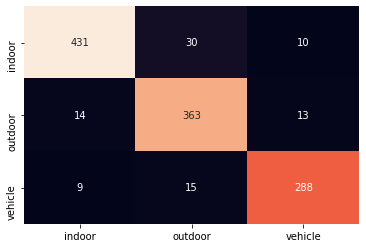

In [656]:
sns.heatmap(confusion_mtx, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names, cbar=False)
plt.autoscale()

In [657]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [658]:
cm = confusion_matrix(Y_true, Y_pred_classes)

In [659]:
cm

array([[431,  30,  10],
       [ 14, 363,  13],
       [  9,  15, 288]], dtype=int64)

Confusion matrix, without normalization
[[431  30  10]
 [ 14 363  13]
 [  9  15 288]]


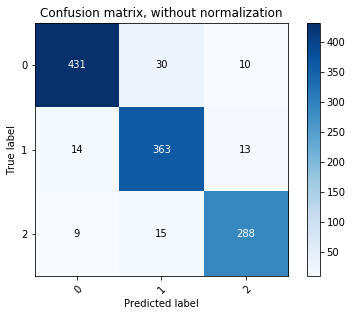

In [660]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred_classes, classes=target_names,
                      title='Confusion matrix, without normalization')
plt.autoscale()

Normalized confusion matrix
[[0.91507431 0.06369427 0.02123142]
 [0.03589744 0.93076923 0.03333333]
 [0.02884615 0.04807692 0.92307692]]


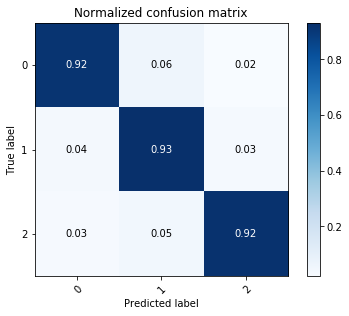

In [661]:
# Plot normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred_classes, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')
plt.autoscale()

In [662]:
print("F1 Score: ", f1_score(Y_true, Y_pred_classes, average="macro"))
print("Precision Score: ", precision_score(Y_true, Y_pred_classes, average="macro"))
print("Recall Score: ", recall_score(Y_true, Y_pred_classes, average="macro"))
print(classification_report(Y_true, Y_pred_classes, target_names=target_names, digits=4))

F1 Score:  0.9220749718206843
Precision Score:  0.9216967018261899
Recall Score:  0.9229734879416408
              precision    recall  f1-score   support

      indoor     0.9493    0.9151    0.9319       471
     outdoor     0.8897    0.9308    0.9098       390
     vehicle     0.9260    0.9231    0.9246       312

    accuracy                         0.9224      1173
   macro avg     0.9217    0.9230    0.9221      1173
weighted avg     0.9233    0.9224    0.9226      1173



# PCA plots

In [601]:
new_model = load_model('DCASE_2017_mfccs_1D_k4.h5')
new_model.save_weights('weights_same_filter.h5')
new_model.load_weights('weights_same_filter.h5') 

In [604]:
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 25, 32)            96        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 32)            2080      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)              

In [617]:
auto_features = new_model.layers[5].output[0]

In [618]:
auto_features.shape

TensorShape([5, 32])

In [620]:
auto_feats_df = pd.DataFrame(auto_features)
print(auto_feats_df.head())
auto_feats_df.to_csv('auto_train_features_same' + '.csv.gz',compression='gzip', index=False, header=None)

                                                  0   \
0  Tensor("strided_slice_171:0", shape=(), dtype=...   
1  Tensor("strided_slice_203:0", shape=(), dtype=...   
2  Tensor("strided_slice_235:0", shape=(), dtype=...   
3  Tensor("strided_slice_267:0", shape=(), dtype=...   
4  Tensor("strided_slice_299:0", shape=(), dtype=...   

                                                  1   \
0  Tensor("strided_slice_172:0", shape=(), dtype=...   
1  Tensor("strided_slice_204:0", shape=(), dtype=...   
2  Tensor("strided_slice_236:0", shape=(), dtype=...   
3  Tensor("strided_slice_268:0", shape=(), dtype=...   
4  Tensor("strided_slice_300:0", shape=(), dtype=...   

                                                  2   \
0  Tensor("strided_slice_173:0", shape=(), dtype=...   
1  Tensor("strided_slice_205:0", shape=(), dtype=...   
2  Tensor("strided_slice_237:0", shape=(), dtype=...   
3  Tensor("strided_slice_269:0", shape=(), dtype=...   
4  Tensor("strided_slice_301:0", shape=(), dty

In [593]:
X_val = X_val.reshape(X_val.shape[0], -1)

In [594]:
X_val.shape

(1173, 26)

Variance PCA: 0.8930440186734979


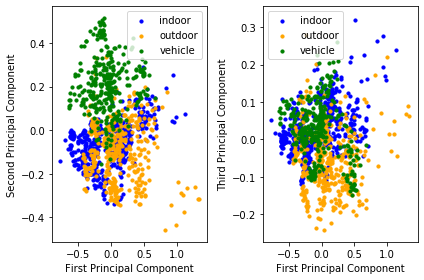

In [595]:
pca = PCA(n_components=3)
 
pca_result = pca.fit_transform(X_val)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
 
Xax=pca_result[:,0]
Yax=pca_result[:,1]
Zax=pca_result[:,2]
 
labels=['indoor', 'outdoor', 'vehicle']
 
cdict={0:'blue', 1:'orange', 2:'green'}
labl={0:'indoor', 1:'outdoor', 2:'vehicle'}
marker={0:'*', 1:'o', 2:'+'}
alpha={0:.3, 1:.5, 2:.7}
y_val = np.argmax(y_val, axis = 1) 
 
fig, (ax1, ax2) = plt.subplots(1, 2)
for g in np.unique(y_val):
    ix = np.where(y_val == g)
    ax1.scatter(Xax[ix], Yax[ix], c = cdict[g], label = labl[g], s = 10)
    ax2.scatter(Xax[ix], Zax[ix], c = cdict[g], label = labl[g], s = 10)
ax1.legend()
ax2.legend()
ax1.set_xlabel("First Principal Component",fontsize=10)
ax1.set_ylabel("Second Principal Component",fontsize=10)
ax2.set_xlabel("First Principal Component",fontsize=10)
ax2.set_ylabel("Third Principal Component",fontsize=10)
plt.tight_layout()

In [78]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_val)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1173 samples in 0.005s...
[t-SNE] Computed neighbors for 1173 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1173
[t-SNE] Computed conditional probabilities for sample 1173 / 1173
[t-SNE] Mean sigma: 0.097139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.573429
[t-SNE] KL divergence after 300 iterations: 0.592000
t-SNE done! Time elapsed: 1.7486579418182373 seconds


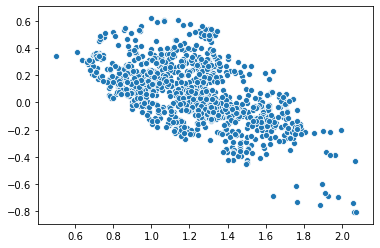

In [88]:
sns.scatterplot(X_val[:,0], X_val[:,1], legend='full')

# 2D Convolution Parameters

In [ ]:
NB_ROWS = 13     # corresponds to number of mfccs
NB_COLS = 431    # correponds to the size of mfccs[i] (one mfcc)
CHANNEL = 1      # the number of channels
 
X_train = np.array(X_train)
X_val = np.array(X_val)
 
# Reshaping to perform 2D convolution
X_train_2D_cnn = X_train.reshape(X_train.shape[0], NB_ROWS, NB_COLS, CHANNEL)
X_test_2D_cnn = X_val.reshape(X_val.shape[0], NB_ROWS, NB_COLS, CHANNEL)
 
y_train_2D_cnn_hot = y_train
y_test_2D_cnn_hot = y_val
 
print("[INFO] X_train_2D_cnn.shape = {}, y_train_2D_cnn_hot.shape = {} ".format(X_train_2D_cnn.shape, 
                                                                                y_train_2D_cnn_hot.shape))
print("[INFO] X_test_2D_cnn.shape = {}, y_test_2D_cnn_hot.shape = {} ".format(X_test_2D_cnn.shape, 
                                                                              y_test_2D_cnn_hot.shape))
 
# debug
print("[DEBUG] y_train_2D_cnn_hot.shape = {}, y_train_2D_cnn_hot[0] = {}".format(y_train_2D_cnn_hot.shape, 
                                                                                 y_train_2D_cnn_hot[0]))
print("[DEBUG] y_test_2D_cnn_hot.shape = {}, y_test_2D_cnn_hot[0] = {}".format(y_test_2D_cnn_hot.shape, 
                                                                               y_test_2D_cnn_hot[0]))

In [ ]:
def construct_model(input_shape=(13, 431, 1), num_classes = 3):
     
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.25))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax', name="output_layer"))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    model.summary()
     
    inp = model.input                                                               # input placeholder
    outputs = [layer.output for layer in model.layers]                              # all layer outputs
    functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions
     
    return model

In [ ]:
epochs = 100
batch_size = 32
verbose = 1
num_classes = 3
input_shape = (NB_ROWS, NB_COLS, CHANNEL)
 
outputFolder = "D:\\Extrasensory_Journal"
 
# Create the model and fit it
start = time.time()
model = construct_model(input_shape=input_shape, num_classes=num_classes)
filepath = outputFolder + "\\DCASE_2017-mfccs-weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss',
                             verbose=verbose,
                             save_best_only=True,
                             save_weights_only=True, 
                             mode='auto')
 
earlystop = EarlyStopping(monitor='val_loss', 
                          patience=7,
                          verbose=verbose, 
                          mode='auto')
 
callbacks_list = [checkpoint, earlystop]
history = model.fit(X_train_2D_cnn, 
                    y_train_2D_cnn_hot, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    callbacks=callbacks_list,
                    verbose=verbose, 
                    validation_data=(X_test_2D_cnn, y_test_2D_cnn_hot))
end = time.time()
 
print("[INFO] Model trained in {} ms".format((end-start)))
model.save('DCASE_2017_mfccs.h5')

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(dpi=120)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

 
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" %
      (100*history.history['accuracy'][-1], 100*history.history['val_accuracy'][-1]))

# Extrasensory Dataset

In [663]:
labels_dir = r"D:\Extrasensory_Journal\labels"
total_files = glob.glob(labels_dir + "\\" + "*.gz")
uuid_list = []
for i in range(len(total_files)):
    uuid = total_files[i][31:67]
    uuid_list.append(uuid)
    
user_data_file = labels_dir + '\\' + '%s.features_labels.csv.gz' % uuid_list

In [664]:
user_data_file

"D:\\Extrasensory_Journal\\labels\\['00EABED2-271D-49D8-B599-1D4A09240601', '098A72A5-E3E5-4F54-A152-BBDA0DF7B694', '0A986513-7828-4D53-AA1F-E02D6DF9561B', '0BFC35E2-4817-4865-BFA7-764742302A2D', '0E6184E1-90C0-48EE-B25A-F1ECB7B9714E', '1155FF54-63D3-4AB2-9863-8385D0BD0A13', '11B5EC4D-4133-4289-B475-4E737182A406', '136562B6-95B2-483D-88DC-065F28409FD2', '1538C99F-BA1E-4EFB-A949-6C7C47701B20', '1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842', '24E40C4C-A349-4F9F-93AB-01D00FB994AF', '27E04243-B138-4F40-A164-F40B60165CF3', '2C32C23E-E30C-498A-8DD2-0EFB9150A02E', '33A85C34-CFE4-4732-9E73-0A7AC861B27A', '3600D531-0C55-44A7-AE95-A7A38519464E', '40E170A7-607B-4578-AF04-F021C3B0384A', '481F4DD2-7689-43B9-A2AA-C8772227162B', '4E98F91F-4654-42EF-B908-A3389443F2E7', '4FC32141-E888-4BFF-8804-12559A491D8C', '5119D0F8-FCA8-4184-A4EB-19421A40DE0D', '5152A2DF-FAF3-4BA8-9CA9-E66B32671A53', '59818CD2-24D7-4D32-B133-24C2FE3801E5', '59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2', '5EF64122-B513-46AE-BCF1-E62AAC285D2C', '613

In [665]:
file_names = os.listdir(labels_dir + '\\')
user_ids = [fn.split(".")[0] for fn in file_names]

In [666]:
user_ids

['00EABED2-271D-49D8-B599-1D4A09240601',
 '098A72A5-E3E5-4F54-A152-BBDA0DF7B694',
 '0A986513-7828-4D53-AA1F-E02D6DF9561B',
 '0BFC35E2-4817-4865-BFA7-764742302A2D',
 '0E6184E1-90C0-48EE-B25A-F1ECB7B9714E',
 '1155FF54-63D3-4AB2-9863-8385D0BD0A13',
 '11B5EC4D-4133-4289-B475-4E737182A406',
 '136562B6-95B2-483D-88DC-065F28409FD2',
 '1538C99F-BA1E-4EFB-A949-6C7C47701B20',
 '1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842',
 '24E40C4C-A349-4F9F-93AB-01D00FB994AF',
 '27E04243-B138-4F40-A164-F40B60165CF3',
 '2C32C23E-E30C-498A-8DD2-0EFB9150A02E',
 '33A85C34-CFE4-4732-9E73-0A7AC861B27A',
 '3600D531-0C55-44A7-AE95-A7A38519464E',
 '40E170A7-607B-4578-AF04-F021C3B0384A',
 '481F4DD2-7689-43B9-A2AA-C8772227162B',
 '4E98F91F-4654-42EF-B908-A3389443F2E7',
 '4FC32141-E888-4BFF-8804-12559A491D8C',
 '5119D0F8-FCA8-4184-A4EB-19421A40DE0D',
 '5152A2DF-FAF3-4BA8-9CA9-E66B32671A53',
 '59818CD2-24D7-4D32-B133-24C2FE3801E5',
 '59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2',
 '5EF64122-B513-46AE-BCF1-E62AAC285D2C',
 '61359772-D8D8-

In [667]:
activity_labels_name = ['label:BICYCLING', 'label:SLEEPING', 'label:LAB_WORK',
                        'label:IN_CLASS', 'label:IN_A_MEETING', 'label:LOC_main_workplace',
                        'label:OR_indoors', 'label:OR_outside', 'label:IN_A_CAR',
                        'label:ON_A_BUS', 'label:DRIVE_-_I_M_THE_DRIVER',
                        'label:DRIVE_-_I_M_A_PASSENGER', 'label:LOC_home',
                        'label:FIX_restaurant', 'label:COOKING', 'label:SHOPPING',
                        'label:BATHING_-_SHOWER', 'label:CLEANING', 'label:DOING_LAUNDRY',
                        'label:WASHING_DISHES', 'label:WATCHING_TV',
                        'label:SURFING_THE_INTERNET', 'label:AT_A_PARTY', 'label:AT_A_BAR',
                        'label:LOC_beach', 'label:COMPUTER_WORK', 'label:EATING', 'label:TOILET',
                        'label:AT_THE_GYM', 'label:ELEVATOR', 'label:AT_SCHOOL']

In [668]:
def clean_labels(labels_df):
    labels = []
    for ind, row in labels_df.iterrows():
        max_label = np.argmax(row)
        if np.isnan(np.max(row)):
            label = max_label
        else:
            if ":" in max_label:
                label = max_label.split(":")[1]
            else:
                label=max_label
        labels.append(label)
    return pd.Series(labels)

In [669]:
total_files = []

for i in tqdm(range(len(user_ids))):
    with gzip.open(labels_dir + '\\' + '%s.features_labels.csv.gz' % uuid_list[i], 'rb') as fid:
        csv_str = fid.read()
        csv_str = csv_str.decode("utf-8")
        df = pd.read_csv(StringIO(csv_str), sep=",")
        aud_col_name = [col for col in df.columns if "audio_naive" in col]
        label_col_name = [col for col in df.columns if "label" in col]
        aud_features_df = df[df.columns.intersection(aud_col_name)]
        aud_labels_df = df[df.columns.intersection(activity_labels_name)]
        null_ind = []
        for ind, row in aud_features_df.iterrows():
            if row.isnull().sum() > 0:
                null_ind.append(ind)
        aud_features_df.drop(aud_features_df.index[null_ind])
        features_df = df[df.columns.intersection(aud_col_name)]
        labels_df = clean_labels(df[df.columns.intersection(activity_labels_name)])
        user_df = pd.concat((features_df, labels_df), axis=1)
        user_df = user_df.rename(columns={0:'label'})
        user_df = user_df.dropna(subset=aud_col_name)
    total_files.append(user_df)

c:\anaconda3\envs\audio\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


In [670]:
len(total_files)

60

In [671]:
total_files[12]

,audio_naive:mfcc0:mean,audio_naive:mfcc1:mean,audio_naive:mfcc2:mean,audio_naive:mfcc3:mean,audio_naive:mfcc4:mean,audio_naive:mfcc5:mean,audio_naive:mfcc6:mean,audio_naive:mfcc7:mean,audio_naive:mfcc8:mean,audio_naive:mfcc9:mean,...,audio_naive:mfcc4:std,audio_naive:mfcc5:std,audio_naive:mfcc6:std,audio_naive:mfcc7:std,audio_naive:mfcc8:std,audio_naive:mfcc9:std,audio_naive:mfcc10:std,audio_naive:mfcc11:std,audio_naive:mfcc12:std,label
0,-7.493934,1.132357,-1.481641,-0.609155,-1.884579,-0.723755,-1.509845,-1.296577,-1.031879,-0.858312,...,0.510382,0.555430,0.523345,0.568588,0.511616,0.427119,0.396342,0.345990,0.363974,LOC_main_workplace
1,-16.644125,1.127306,-1.613793,0.073209,-2.379395,-1.240171,-1.452657,-0.779496,-1.188198,-1.024485,...,0.805336,0.610477,0.524813,0.449804,0.424010,0.412729,0.382305,0.412478,0.391811,LOC_main_workplace
2,-10.983519,0.698184,-2.333403,0.180645,-2.180235,-1.605858,-1.543334,-0.740051,-1.115495,-1.324189,...,0.901649,0.784975,0.611697,0.608474,0.548679,0.505119,0.442274,0.508377,0.427276,LOC_main_workplace
3,-6.551388,0.923646,-1.788636,-0.164324,-1.670335,-0.877576,-1.756758,-1.075317,-0.915945,-0.787203,...,0.489812,0.500648,0.415977,0.365358,0.435269,0.375630,0.324262,0.377912,0.429580,LOC_main_workplace
4,-9.963111,0.816774,-2.582453,-0.067254,-1.856917,-1.877418,-1.070526,-1.074659,-1.153333,-0.587026,...,0.908778,0.928819,0.705012,0.524026,0.433654,0.496789,0.481470,0.551463,0.463331,LOC_main_workplace
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8511,-13.116293,-0.914629,-2.665949,-0.780978,-1.573263,-0.769585,-1.078831,-0.759488,-0.977628,-0.577545,...,0.335592,0.342954,0.298590,0.286581,0.237058,0.202900,0.234110,0.211452,0.217197,LOC_main_workplace
8512,-18.667990,0.203154,-2.600906,-1.090961,-1.906121,-0.846700,-1.244847,-0.997262,-0.928192,-0.690187,...,0.568241,0.580355,0.399977,0.423955,0.357605,0.370175,0.346245,0.303912,0.313538,LOC_main_workplace
8513,-14.759271,-1.505725,-2.646897,-0.574547,-1.405688,-0.630806,-1.301339,-0.867155,-1.066245,-0.600430,...,0.482124,0.438928,0.357717,0.292932,0.288334,0.247215,0.249159,0.222117,0.233041,LOC_main_workplace
8514,-9.185555,1.311587,-1.879049,-0.185477,-1.001206,-0.458974,-0.892135,-0.551578,-0.792127,-0.534134,...,0.395325,0.349274,0.312004,0.260925,0.242496,0.229507,0.209279,0.204197,0.204898,LOC_main_workplace


In [672]:
df_with_nan = []
df_without_nans = []
for i, df in enumerate(total_files):
    if df.isnull().values.any():
        df_with_nan.append(i)
    else:
        df_without_nans.append(i)

In [673]:
df_with_nan

[48, 59]

In [674]:
total_files = [total_files[i] for i in df_without_nans]

In [675]:
for i in range(len(total_files)):
    print(total_files[i].isnull().values.any())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [676]:
final_files = pd.concat(total_files)

In [677]:
final_files['label'].unique()

array(['IN_A_MEETING', 'LOC_main_workplace', 'SLEEPING', 'OR_indoors',
       'LOC_home', 'ON_A_BUS', 'IN_CLASS', 'SHOPPING', 'EATING',
       'COOKING', 'BICYCLING', 'OR_outside', 'LAB_WORK', 'COMPUTER_WORK',
       'AT_SCHOOL', 'IN_A_CAR', 'SURFING_THE_INTERNET', 'LOC_beach',
       'WATCHING_TV', 'DRIVE_-_I_M_A_PASSENGER', 'DRIVE_-_I_M_THE_DRIVER',
       'DOING_LAUNDRY', 'WASHING_DISHES', 'CLEANING', 'FIX_restaurant',
       'AT_A_PARTY', 'ELEVATOR', 'TOILET'], dtype=object)

In [678]:
len(final_files['label'].unique())

28

In [679]:
final_files['label'] = final_files['label'].replace(['IN_A_MEETING', 'LOC_main_workplace', 'SLEEPING', 'OR_indoors', 'LOC_home',
                                             'IN_CLASS', 'EATING', 'COOKING', 'LAB_WORK', 'COMPUTER_WORK',
                                             'AT_SCHOOL', 'SURFING_THE_INTERNET', 'WATCHING_TV', 'DOING_LAUNDRY', 
                                             'WASHING_DISHES', 'CLEANING', 'FIX_restaurant', 'AT_A_PARTY',
                                             'ELEVATOR', 'TOILET'], 
                                            ['indoor', 'indoor', 'indoor', 'indoor', 'indoor', 'indoor', 'indoor', 'indoor',
                                             'indoor', 'indoor', 'indoor', 'indoor', 'indoor',
                                             'indoor', 'indoor', 'indoor', 'indoor', 'indoor', 'indoor', 'indoor'])


final_files['label'] = final_files['label'].replace(['BICYCLING', 'ON_A_BUS', 'IN_A_CAR', 'DRIVE_-_I_M_A_PASSENGER', 
                                             'DRIVE_-_I_M_THE_DRIVER'], 
                                            ['vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle'])

final_files['label'] = final_files['label'].replace(['OR_outside', 'SHOPPING', 'LOC_beach'], 
                                            ['outdoor', 'outdoor', 'outdoor'])

In [680]:
final_files['label'].unique()

array(['indoor', 'vehicle', 'outdoor'], dtype=object)

In [681]:
y_test = final_files.iloc[:,-1]

In [682]:
y_test

0       indoor
1       indoor
2       indoor
3       indoor
4       indoor
         ...  
2261    indoor
2262    indoor
2263    indoor
2264    indoor
2265    indoor
Name: label, Length: 354549, dtype: object

In [683]:
X_test = final_files.iloc[:, 0:26]

In [684]:
X_test

,audio_naive:mfcc0:mean,audio_naive:mfcc1:mean,audio_naive:mfcc2:mean,audio_naive:mfcc3:mean,audio_naive:mfcc4:mean,audio_naive:mfcc5:mean,audio_naive:mfcc6:mean,audio_naive:mfcc7:mean,audio_naive:mfcc8:mean,audio_naive:mfcc9:mean,...,audio_naive:mfcc3:std,audio_naive:mfcc4:std,audio_naive:mfcc5:std,audio_naive:mfcc6:std,audio_naive:mfcc7:std,audio_naive:mfcc8:std,audio_naive:mfcc9:std,audio_naive:mfcc10:std,audio_naive:mfcc11:std,audio_naive:mfcc12:std
0,-4.219657,-0.012806,-1.298291,0.094373,-1.220977,-0.851300,-1.656516,-0.898563,-0.503573,-0.518072,...,0.670053,0.389200,0.535904,0.468701,0.358315,0.401412,0.408432,0.277176,0.416881,0.263832
1,-7.505606,1.294372,-0.745550,-0.052791,-1.220453,-0.822848,-1.559542,-0.835154,-0.665443,-0.580521,...,0.669467,0.499003,0.584068,0.525900,0.435339,0.459064,0.391962,0.341445,0.362252,0.298252
2,-7.966769,1.309082,-0.770455,0.080046,-1.238489,-0.922404,-1.695809,-0.864904,-0.670674,-0.580025,...,0.803958,0.546688,0.562475,0.559488,0.445827,0.472388,0.462703,0.359176,0.430171,0.330055
3,-5.367933,0.182373,-0.891874,0.112003,-1.437741,-0.770266,-1.646552,-0.922945,-0.614741,-0.531608,...,0.821571,0.519879,0.572094,0.591143,0.467151,0.453082,0.459266,0.325971,0.379887,0.389737
4,-13.415772,0.908387,-1.442258,-0.294636,-1.760813,-1.104186,-1.523959,-1.005763,-0.577766,-0.579184,...,0.902605,0.777665,0.678277,0.652441,0.492996,0.455644,0.466388,0.368922,0.393817,0.331128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,7.620324,-0.956735,0.587310,0.634542,-0.016997,-0.140553,0.307518,0.039101,0.055642,0.154290,...,0.242027,0.234193,0.195252,0.194742,0.118630,0.138211,0.123376,0.100841,0.104371,0.102416
2262,6.882607,-0.822229,0.811413,0.395041,0.245297,-0.084122,0.376161,0.189670,0.009715,0.076512,...,0.190360,0.185548,0.224232,0.140518,0.127884,0.143605,0.112262,0.107523,0.102927,0.091318
2263,3.896036,-0.362770,1.202823,0.474777,0.379865,-0.005502,0.440664,0.013803,0.056842,-0.003680,...,0.272054,0.256302,0.217812,0.194657,0.155643,0.153459,0.116204,0.116547,0.098003,0.098819
2264,4.151635,0.821539,-0.041935,0.180841,0.341755,0.054328,0.284079,-0.090710,0.183090,-0.018988,...,0.248828,0.208725,0.177066,0.169816,0.139462,0.189611,0.101193,0.104274,0.112393,0.092398


In [685]:
X_test_scaled = StandardScaler().fit_transform(X_test.values)

In [686]:
X_test_scaled

array([[-0.3859221 ,  0.09782236, -0.39261037, ...,  0.58536333,
         1.96104625,  0.65312279],
       [-0.80531602,  0.84664867, -0.08310378, ...,  1.1528378 ,
         1.46144861,  0.98175022],
       [-0.86417541,  0.8550754 , -0.0970493 , ...,  1.3093968 ,
         2.08258706,  1.28539165],
       ...,
       [ 0.64990417, -0.10265704,  1.00788509, ..., -0.83293877,
        -0.95518318, -0.92235071],
       [ 0.68252692,  0.57578289,  0.3108845 , ..., -0.94130539,
        -0.82358256, -0.98365567],
       [ 0.6593038 ,  0.36645743,  0.86521689, ..., -0.91163767,
        -0.79046749, -0.84824246]])

In [687]:
X_test_scaled.shape

(354549, 26)

In [688]:
test_label_encoder = LabelEncoder().fit(y_test)
test_labels = train_label_encoder.transform(y_test)
classes_test = list(test_label_encoder.classes_)

In [689]:
classes_test

['indoor', 'outdoor', 'vehicle']

In [690]:
y_test_new = np_utils.to_categorical(test_labels)

In [691]:
X_test_new = X_test_scaled.reshape(len(X_test_scaled),26,1)
Y_prediction = model.predict(X_test_new)
Y_pred_classes = np.argmax(Y_prediction, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_new, axis = 1) 
# compute the confusion matrix
target_names = ['indoor', 'outdoor', 'vehicle']
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

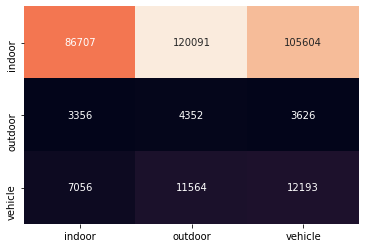

In [692]:
sns.heatmap(confusion_mtx, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names, cbar=False)
plt.autoscale()

In [693]:
print("F1 Score: ", f1_score(Y_true, Y_pred_classes, average="macro"))
print("Precision Score: ", precision_score(Y_true, Y_pred_classes, average="macro"))
print("Recall Score: ", recall_score(Y_true, Y_pred_classes, average="macro"))
print(classification_report(Y_true, Y_pred_classes, target_names=target_names, digits=4))
print("Accuracy: ", accuracy_score(Y_true, Y_pred_classes))

F1 Score:  0.21423834878577197
Precision Score:  0.34173573982119776
Recall Score:  0.352412151895727
              precision    recall  f1-score   support

      indoor     0.8928    0.2775    0.4235    312402
     outdoor     0.0320    0.3840    0.0591     11334
     vehicle     0.1004    0.3957    0.1602     30813

    accuracy                         0.2912    354549
   macro avg     0.3417    0.3524    0.2142    354549
weighted avg     0.7964    0.2912    0.3889    354549

Accuracy:  0.29122067753681435


Normalized confusion matrix
[[0.27754944 0.38441175 0.33803881]
 [0.29610023 0.38397741 0.31992236]
 [0.22899426 0.37529614 0.3957096 ]]


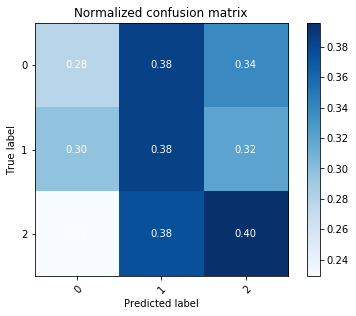

In [694]:
# Plot normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred_classes, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')
plt.autoscale()

In [695]:
x_train, x_test, y_train, y_test = train_test_split(X_test_scaled, y_test_new, test_size=0.1, shuffle=False)

In [696]:
x_train = x_train.reshape(x_train.shape[0], NB_ROWS, NB_COLS)
x_test = x_test.reshape(x_test.shape[0], NB_ROWS, NB_COLS)

In [697]:
model_new = load_model("DCASE_2017_mfccs_1D.h5")
score = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss 1:', score[0])
print('Test accuracy 1:', score[1])
model_new.fit(x_train, y_train,batch_size=32,epochs=1,verbose=0)
score = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss 2:', score[0])
print('Test accuracy 2:', score[1])

Test loss 1: 30.195457392956346
Test accuracy 1: 0.2523198425769806
Test loss 2: 0.4393749811907881
Test accuracy 2: 0.8564659357070923


In [557]:
Y_prediction = model_new.predict(x_test)
Y_pred_classes = np.argmax(Y_prediction, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
target_names = ['indoor', 'outdoor', 'vehicle']
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

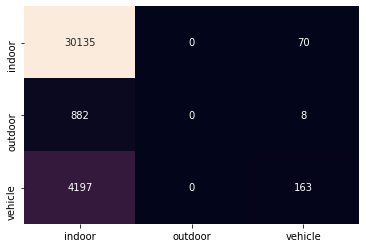

In [558]:
sns.heatmap(confusion_mtx, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names, cbar=False)
plt.autoscale()

In [559]:
print("F1 Score: ", f1_score(Y_true, Y_pred_classes, average="macro"))
print("Precision Score: ", precision_score(Y_true, Y_pred_classes, average="macro"))
print("Recall Score: ", recall_score(Y_true, Y_pred_classes, average="macro"))
print(classification_report(Y_true, Y_pred_classes, target_names=target_names))
print("Accuracy: ", accuracy_score(Y_true, Y_pred_classes))

c:\anaconda3\envs\audio\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score:  0.3307153805110103


c:\anaconda3\envs\audio\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision Score:  0.5107053800508897
Recall Score:  0.34502260799926293


c:\anaconda3\envs\audio\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      indoor       0.86      1.00      0.92     30205
     outdoor       0.00      0.00      0.00       890
     vehicle       0.68      0.04      0.07      4360

    accuracy                           0.85     35455
   macro avg       0.51      0.35      0.33     35455
weighted avg       0.81      0.85      0.79     35455

Accuracy:  0.854548018615146


Normalized confusion matrix
[[0.9976825  0.         0.0023175 ]
 [0.99101124 0.         0.00898876]
 [0.96261468 0.         0.03738532]]


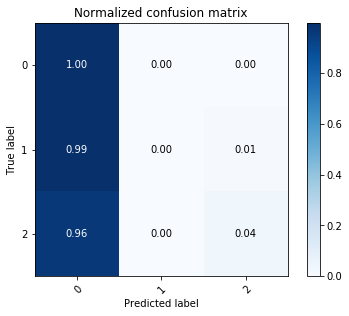

In [560]:
# Plot normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred_classes, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')
plt.autoscale()

In [464]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
clf_RF = RandomForestClassifier()

In [417]:
len(x_train)

319094

In [418]:
clf_RF.fit(x_train, y_train) 

c:\anaconda3\envs\audio\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [419]:
y_pred = clf_RF.predict(x_test)

In [420]:
clf_RF.score(x_test, y_test)

0.8770272175997743

In [421]:
Y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
target_names = ['indoor', 'outdoor', 'vehicle']
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

In [422]:
print(classification_report(Y_true, Y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

      indoor       0.90      0.99      0.95     31140
     outdoor       0.87      0.13      0.22      1190
     vehicle       0.79      0.24      0.37      3125

    accuracy                           0.90     35455
   macro avg       0.85      0.45      0.51     35455
weighted avg       0.89      0.90      0.87     35455



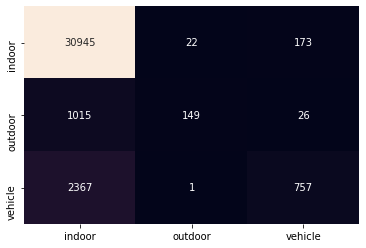

In [423]:
sns.heatmap(confusion_mtx, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names, cbar=False)
plt.autoscale()

Normalized confusion matrix
[[9.93737958e-01 7.06486834e-04 5.55555556e-03]
 [8.52941176e-01 1.25210084e-01 2.18487395e-02]
 [7.57440000e-01 3.20000000e-04 2.42240000e-01]]


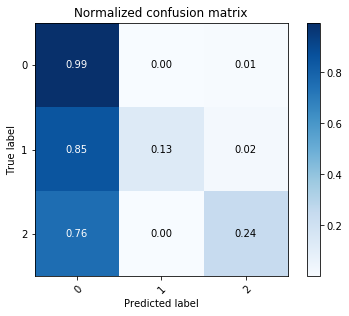

In [424]:
# Plot normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred_classes, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')
plt.autoscale()

In [436]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [437]:
rc_rf = GradientBoostingClassifier()

In [438]:
eclf = VotingClassifier(estimators=[('1D_CNN', rc_rf), ('rf', clf_RF)], voting='hard')

In [439]:
eclf

VotingClassifier(estimators=[('1D_CNN',
                              GradientBoostingClassifier(criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                           

In [450]:
y_test1 = np.argmax(y_test, axis=1)

In [453]:
np.unique(y_test1)

array([0, 1, 2], dtype=int64)

In [443]:
.fit(x_train, y_train) 

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [ ]:
def read_raw_user_data(uuid, timestamps):
    postfix = ".sound.mfcc"
    user_data_dir = uuid
    total_files = []
    for timestamp in timestamps:
        file_name = uuid + "\\" + ("%s" % timestamp) + postfix
        raw_file = np.fromfile(file_name)
        total_files.append(raw_file)
    return total_files

In [ ]:
audio_features = r"D:\Extrasensory_Journal\audio_naive"
uuid = audio_features + '\\' + '%s' % uuid_list[0]
timestamps = df_final['timestamp']
final_files = read_raw_user_data(uuid, timestamps)

In [ ]:
fold = 0

print("Starting fold: ", fold)
train_df_fold_iphone = pd.read_csv("es_cv_5_folds/fold_" + str(fold) + "_train_iphone_uuids.txt", names=['UUID'])
train_df_fold_android = pd.read_csv("es_cv_5_folds/fold_" + str(fold) + "_train_android_uuids.txt", names=['UUID'])
train_df_fold = pd.concat([train_df_fold_iphone, train_df_fold_android])
train_uuids = train_df_fold['UUID'].values.tolist()

test_df_fold_iphone = pd.read_csv("es_cv_5_folds/fold_" + str(fold) + "_test_iphone_uuids.txt", names=['UUID'])
test_df_fold_android = pd.read_csv("es_cv_5_folds/fold_" + str(fold) + "_test_android_uuids.txt", names=['UUID'])
test_df_fold = pd.concat([test_df_fold_iphone, test_df_fold_android])
test_uuids = test_df_fold['UUID'].values.tolist()

In [ ]:
test_uuids

In [ ]:
len(final_files)

In [ ]:
test_file = np.fromfile("D:\\Extrasensory_Journal\\audio_naive\\00EABED2-271D-49D8-B599-1D4A09240601\\1444079161.sound.mfcc")

In [ ]:
test_file.shape

In [ ]:
431*13

In [ ]:
len(final_files[124])